# Exploring Data Summary from TILDE, Application to DART data

## &nbsp;Table of contents
### 1. Introduction
### 2. Building the Basic TILDE Query
### 3. Building a TILDE Query with a specific domain
### 4. Find station locations and display on a map
### 5. Station data and data range graphs

## &nbsp;1. Introduction

In this tutorial we will be learning how to use Python to query the TILDE API `Data Summary` endpoint. To highlight different functionalities and the data available we will be using the DART (Deep-ocean Assessment and Reporting of Tsunamis) dataset. TILDE is the API (Application Programmatic Interface) to access its DART data. You do not need to know anything about APIs to use this tutorial. If you would like more info see https://tilde.geonet.org.nz/v2/api-docs/. We developed this tutorial before detided data were available, and haven't added any specific sections since it became available, but the user can replace `water-height` with `water-height-detided` in any part of code to get the corresponding detided data.

This tutorial assumes you have basic knowledge of Python.

###### About GeoNet DART data

GeoNet uses the 12 DART Tsunameters deployed offshore New Zealand and around the Southwestern Pacific Ocean to monitor ocean height. When a change has been detected of a certain magnitude, the buoy will "trigger" and go into a heightened detection mode. The DARTs have two operational reporting modes; standard and event. When in standard reporting mode, the BPR (bottom pressure recorder) and buoy system send four six-hour bundles of 15 minute water height values. When in event reporting mode, BPR data are sampled at 15 second intervals and are sent more frequently. The buoy surface location (latitude and longitude) will also be sent daily. <br>
TILDE provides access to the 15 minutes and 15 second sampled data.

For more DART information see the GeoNet page: https://www.geonet.org.nz/tsunami/dart

## &nbsp;2. Building the Basic TILDE Query

###### Import required modules and set the source URL

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
source = 'https://tilde.geonet.org.nz/v2'

### A basic query with no parameters applied

This query returns information on the different data domains held in TILDE. The query uses the 'dataSummary' endpoint as `https://tilde.geonet.org.nz/v2/dataSummary/`.

######  Set the URL of a basic data summary query

In [3]:
url = source+'/dataSummary/'

In [4]:
r = requests.get(url)
print (r)

<Response [200]>


We use `requests.get` to retrieve the data from the URL. The response status code says whether we were successful in getting the data requested and why not if we were unsuccessful:
<ul>
<li>200 -- everything went okay, and the result has been returned (if any)
<li>301 -- the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
<li>400 -- the server thinks you made a bad request. This can happen when you don't send along the right data, among other things.
<li>404 -- the resource you tried to access wasn't found on the server.
</ul>

###### Store the response as a nested dictionary and see the output

A nested dictionary in python is a dictionary within a dictionary. It's a collection of dictionaries into one single directory. <br>
In TILDE, each data domain has different entries which sit within that specific domain name. For example, DART data sit within the _dart_ domain. By creating a nested dictionary we can specify the domain and then split it by domain name. 

In [5]:
summary = r.json()
type(summary)

dict

In [6]:
summary

{'domains': {'dart': {'domain_name': 'dart',
   'description': 'Deep-ocean Assessment and Reporting of Tsunami',
   'recordCount': 1436881,
   'seriesCount': 64,
   'stationCount': 12,
   'earliestRecord': '2019-12-13T02:15:00Z',
   'latestRecord': '2022-05-04T12:00:00Z'},
  'envirosensor': {'domain_name': 'envirosensor',
   'description': 'Environmental Sensors',
   'recordCount': 397808,
   'seriesCount': 54,
   'stationCount': 6,
   'earliestRecord': '2022-02-24T04:00:00Z',
   'latestRecord': '2022-05-04T15:50:00Z'}}}

######  Specifying the domains from the summary

Currently only the DART and envirosensor domains exist in TILDE. As more domains become available more details will be shown here. 

In [7]:
domains = summary['domains']
domains

{'dart': {'domain_name': 'dart',
  'description': 'Deep-ocean Assessment and Reporting of Tsunami',
  'recordCount': 1436881,
  'seriesCount': 64,
  'stationCount': 12,
  'earliestRecord': '2019-12-13T02:15:00Z',
  'latestRecord': '2022-05-04T12:00:00Z'},
 'envirosensor': {'domain_name': 'envirosensor',
  'description': 'Environmental Sensors',
  'recordCount': 397808,
  'seriesCount': 54,
  'stationCount': 6,
  'earliestRecord': '2022-02-24T04:00:00Z',
  'latestRecord': '2022-05-04T15:50:00Z'}}

**Access Method 1 - Use the items method to access each entry**
<br>
To have actual information about the domain you can print out the key-value pairs as shown below. In this case we print out various item names that have been returned for our _dart_ domain in the response above. We are printing out each item line by line, with the domain name being at the top. 

In [8]:
#iterate over key,value pairs and print the results
for domain,detail in domains.items():
    print ('For Domain = ', domain)     
    print ('\tDomain name =', detail.get('domain_name'))
    print ('\tDescription =', detail.get('description'))
    print ('\tRecord count =', detail.get('recordCount'))
    print ('\tSeries count =', detail.get('seriesCount'))
    print ('\tStation count =', detail.get('stationCount'))
    print ('\tEarliest record =', detail.get('earliestRecord'))
    print ('\tLatest record =', detail.get('latestRecord'))

For Domain =  dart
	Domain name = dart
	Description = Deep-ocean Assessment and Reporting of Tsunami
	Record count = 1436881
	Series count = 64
	Station count = 12
	Earliest record = 2019-12-13T02:15:00Z
	Latest record = 2022-05-04T12:00:00Z
For Domain =  envirosensor
	Domain name = envirosensor
	Description = Environmental Sensors
	Record count = 397808
	Series count = 54
	Station count = 6
	Earliest record = 2022-02-24T04:00:00Z
	Latest record = 2022-05-04T15:50:00Z


**Access Method 2 - Summary info in table format**
<br>
Pandas dataframes can be quite useful because they enable the user to visualize information in a table instead of line-by-line as shown above. The dataframe calls for the values in the 'domains' variable that we set above and then the 'orient' (orientation) is specified to be the 'index' because we are using the highest level key as the index, and subsidiary keys as columns. As we have two domains, they each have a row, adding more domains would create more rows.

In [9]:
df = pd.DataFrame.from_dict(data=domains, orient='index')
df

,domain_name,description,recordCount,seriesCount,stationCount,earliestRecord,latestRecord
dart,dart,Deep-ocean Assessment and Reporting of Tsunami,1436881,64,12,2019-12-13T02:15:00Z,2022-05-04T12:00:00Z
envirosensor,envirosensor,Environmental Sensors,397808,54,6,2022-02-24T04:00:00Z,2022-05-04T15:50:00Z


**Access Method 3 - Normalizing semi-structured JSON data into a flat table.**
<br>
This is quite similar to the example above, but adds the domain value (e.g. dart) to the beginning of the header of each column. This will then make new columns with the keys as headers for each new domain. This would eventually create a table with a lot of columns if there are many headers and different domains. E.g. See an example below using only two different headers (domain_name and description) but for two domains (dart and gnss). As we have both dart and envirosensor domains, we can see how quickly this will add many columns. 

|&nbsp; | dart.domain_name | dart.description | gnss.domain_name | gnss.description |
| --- | --- | --- | --- | --- |
|0 | dart | Deep-ocean Assessment and Reporting of Tsunami | NaN | NaN |
|1 | NaN | NaN | gnss | Global Navigation Satellite Systems | 

In [10]:
df = pd.json_normalize(domains)
df

,dart.domain_name,dart.description,dart.recordCount,dart.seriesCount,dart.stationCount,dart.earliestRecord,dart.latestRecord,envirosensor.domain_name,envirosensor.description,envirosensor.recordCount,envirosensor.seriesCount,envirosensor.stationCount,envirosensor.earliestRecord,envirosensor.latestRecord
0,dart,Deep-ocean Assessment and Reporting of Tsunami,1436881,64,12,2019-12-13T02:15:00Z,2022-05-04T12:00:00Z,envirosensor,Environmental Sensors,397808,54,6,2022-02-24T04:00:00Z,2022-05-04T15:50:00Z


## &nbsp;3. Building a TILDE Query with a specific domain

This query returns information about the specific data domains provided. <br> 
The query is `https://tilde.geonet.org.nz/v2/dataSummary/[domain]`. For this example we will continue to use the DART domain.

######  Exploring summary for the DART domain
<br>
Following the same steps as above but specifying 'dart' domain after 'dataSummary'

In [11]:
mydomain='dart'
url = 'https://tilde.geonet.org.nz/v2/dataSummary/'+mydomain
r = requests.get(url)
summary = r.json()

#### Find available data types, specifically for `water-height`
For the DART data there are two sampling rates for water-height, the standard mode where data is sampled every 15 minutes (15m) and the trigger mode/higher rate where the water-height is sampled every 15 seconds (15s). 

**Dig down to the specific key for data types**
<br>
This shows the different data methods that are within the summary file, with particular focus on water-height. With this we can see the earliest and latest record for the two different sample rates for water-height. As the higher rate (15s) is only used during the triggered period, using the 'latestRecord' we can see when the last triggered period was. 

In [12]:
datatypes = summary['domain']['dart']['names']['water-height']['methods']
datatypes

{'15m': {'method_name': '15m',
  'aspects': {'nil': {'aspect': 'nil',
    'recordCount': 550056,
    'stationCount': 12,
    'earliestRecord': '2019-12-13T02:15:00Z',
    'latestRecord': '2022-05-04T12:00:00Z'}}},
 '15s': {'method_name': '15s',
  'aspects': {'nil': {'aspect': 'nil',
    'recordCount': 178326,
    'stationCount': 12,
    'earliestRecord': '2020-03-14T10:00:00Z',
    'latestRecord': '2022-03-31T22:59:45Z'}}}}

## &nbsp;4. Find station locations and display on a map

**Access Method 1 - Using the specific key for station metadata**
<br>
Using the summary file we can access the DART station locations

In [13]:
stations = summary['domain']['dart']['stations']

Using station.items we can specify what variables we are after, e.g. station_name, latitude, longitude and then print these. The key used is also the station_name. 

In [14]:
for key,val in stations.items():
    print (key, val['station_name'], val['latitude'], val['longitude'])

NZA NZA -42.371 176.911
NZB NZB -40.599 179.096
NZC NZC -38.2 -179.797
NZD NZD -36.0998 178.6037
NZE NZE -36.049 -177.708
NZF NZF -29.682 -175.009
NZG NZG -23.344 -173.409
NZH NZH -20.087 -171.854
NZI NZI -16.89 -171.198
NZJ NZJ -26.6672 163.9549
NZK NZK -24.3093 169.4988
NZL NZL -19.3096 166.782


**Access Method 2 - Direct to a Pandas dataframe**
<br>
For easier reading we can make this information into a pandas dataframe where we are only focusing on station_name, latitude, and longitude. Which we can specify using `columns=[]`. So the station becomes the dataframe index and the other keys the column names. 

In [15]:
df = pd.DataFrame.from_dict(data=stations, orient='index', columns=['station_name', 'latitude', 'longitude'])
df

,station_name,latitude,longitude
NZA,NZA,-42.3710,176.9110
NZB,NZB,-40.5990,179.0960
NZC,NZC,-38.2000,-179.7970
NZD,NZD,-36.0998,178.6037
NZE,NZE,-36.0490,-177.7080
NZF,NZF,-29.6820,-175.0090
NZG,NZG,-23.3440,-173.4090
NZH,NZH,-20.0870,-171.8540
NZI,NZI,-16.8900,-171.1980
NZJ,NZJ,-26.6672,163.9549


**Map the positions, using the dataframe as the data source**
<br>
Using cartopy https://scitools.org.uk/cartopy/docs/latest/index.html and matplotlib we can then generate a map of the stations using the values (station_name, latitude and longitude) from the pandas dataframe `df` that we generated in the step above. Using the station_name variable we can also plot the names next to the stations using `ax.text`. 

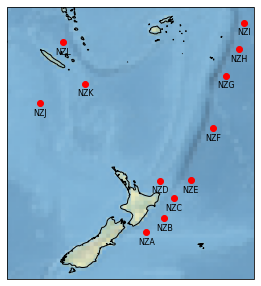

In [16]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([160, 190, -48, -15], crs=ccrs.PlateCarree())

# Put a background image on for nice sea rendering.
ax.stock_img()

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

xx = df['longitude'].values
yy = df['latitude'].values
names = df['station_name'].values
ax.plot(xx, yy, color='red', marker='o', linestyle='None', transform=ccrs.Geodetic())

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', y=-10)

for x, y, n in zip(xx, yy, names):
    ax.text(x, y, n, fontsize=8, verticalalignment='center', horizontalalignment='center', transform=text_transform)
             

## &nbsp;5. Station data and data plots

#### Create a dataframe of station record data (number, earliest, latest) and visualize this in different ways
This function extracts the data we need. We need to step through each level of the nested dictionary, first finding the keys at that level, then iterating through those keys. Finally we assign the results to a pandas dataframe for easy analysis.

In [17]:
def station_data(summary, domain):
    #dataframe for results
    df = pd.DataFrame()
    
    #select just station part of dictionary
    stations = summary['domain'][domain]['stations']

    #get list of stations
    # print ('##Station locations##')
    stationlist = []
    for key,val in stations.items():
        stationlist.append(key)
        # print (key, val['station_name'], val['latitude'], val['longitude'])

    #with each station, get the location information, and the sensor_codes part of the dictionary
    # print('\n')
    # print ('##Station details##')
    for sta in stationlist:
        # print ('##'+sta+'##')
        latitude = stations[sta].get('latitude')
        longitude = stations[sta].get('longitude')
        sensorcodes = stations[sta]['sensor_codes']
        # print (sensorcodes)

        codelist = []
        for key,val in sensorcodes.items():
            codelist.append(key)
            # print ('sensor code = ', val['sensor_code'])
            
        #get the names part
        for code in codelist:
            # print ('code=',code)
            names = sensorcodes[code]['names']

            namelist = []
            for key,val in names.items():
                namelist.append(key)
                # print (sta, code, val['measure_name'])

            #get the methods part    
            for name in namelist:
                # print ('name='+name)
                methods = names[name]['methods']

                methodlist = []
                for key,val in methods.items():
                    methodlist.append(key)
                    
                #get the aspects part    
                for method in methodlist:
                    # print ('method=', method)
                    aspects  = methods[method]['aspects']

                    aspectlist = []
                    for key,val in aspects.items():
                        aspectlist.append(key)
                        # print (sta, code, name, method, val['aspect'])
                        
                        #get the record data
                        for aspect in aspectlist:
                                # print ('aspect=', aspect)
                                records = aspects[aspect]
                                recordcount = records.get('recordCount')
                                earliestrecord = records.get('earliestRecord')
                                latestrecord = records.get('latestRecord')
                                # print (recordcount, earliestrecord, latestrecord)
                                            
                                d = {'station':sta, 'latitude':latitude, 'longitude':longitude, 'sensor_code':code, 'data_name':name, 'data_method':method, 'aspect':aspect, 'record_count':recordcount, 'earliestrecord':earliestrecord, 'latestrecord':latestrecord}
                                df = df.append(d, ignore_index=True)

    df['earliestrecord'] = pd.to_datetime(df['earliestrecord'])
    df['latestrecord'] = pd.to_datetime(df['latestrecord'])
    return(df)

In [18]:
#call function to get main station data, supply the domain name
station_data = station_data(summary, mydomain)
station_data.head(20)

,station,latitude,longitude,sensor_code,data_name,data_method,aspect,record_count,earliestrecord,latestrecord
0,NZA,-42.371,176.911,40,water-height,15m,nil,71956.0,2019-12-21 22:15:00+00:00,2022-01-11 00:00:00+00:00
1,NZA,-42.371,176.911,40,water-height,15s,nil,19803.0,2020-05-08 03:00:00+00:00,2021-12-20 05:24:00+00:00
2,NZA,-42.371,176.911,40,water-height-detided,15m,nil,69652.0,2019-12-21 22:15:00+00:00,2021-12-16 18:00:00+00:00
3,NZA,-42.371,176.911,40,water-height-detided,15s,nil,18482.0,2020-05-08 03:00:00+00:00,2021-12-15 04:59:45+00:00
4,NZA,-42.371,176.911,41,water-height,15m,nil,13175.0,2021-12-18 00:15:00+00:00,2022-05-04 12:00:00+00:00
5,NZA,-42.371,176.911,41,water-height,15s,nil,5377.0,2021-12-20 03:00:00+00:00,2022-01-16 00:59:45+00:00
6,NZA,-42.371,176.911,41,water-height-detided,15m,nil,13175.0,2021-12-18 00:15:00+00:00,2022-05-04 12:00:00+00:00
7,NZA,-42.371,176.911,41,water-height-detided,15s,nil,5137.0,2021-12-20 03:00:00+00:00,2022-01-16 00:59:45+00:00
8,NZB,-40.599,179.096,40,water-height,15m,nil,56870.0,2020-09-18 23:15:00+00:00,2022-05-04 12:00:00+00:00
9,NZB,-40.599,179.096,40,water-height,15s,nil,17246.0,2020-10-28 22:00:00+00:00,2022-01-16 00:59:45+00:00


We can now call the function to get the main station data. By using `df.head()` we are also only asking for the first few lines. If we used `df.tail()` we can see the last few lines. 

**Record count by station and type**
<br>
By using `pd.pivot_table` we can transform the above table, so we can look at different record_counts (15m and 15s) against each station. 

In [19]:
rc = pd.pivot_table(station_data, index='station', values=['record_count'], columns=['sensor_code','data_name','data_method'])
rc.head()

record_count                                                      \
sensor_code           40                                                  41   
data_name   water-height          water-height-detided          water-height   
data_method          15m      15s                  15m      15s          15m   
station                                                                        
NZA              71956.0  19803.0              69652.0  18482.0      13175.0   
NZB              56870.0  17246.0              56870.0  17006.0          NaN   
NZC              72772.0  10896.0              69796.0   9341.0      13854.0   
NZD              27403.0   8288.0              27403.0   7508.0          NaN   
NZE              72005.0  17609.0              67556.0  15688.0      11842.0   

                                                  
sensor_code                                       
data_name           water-height-detided          
data_method     15s                  15m     15s  
station                                           
NZA          5377.0              13175.0  5137.0  
NZB             NaN                  NaN     NaN  
NZC          6569.0              13854.0  6569.0  
NZD             NaN                  NaN     NaN  
NZE          7601.0              11842.0  7361.0

We can then plot this as a bar plot using `plot.bar`. This allows us to visualize the number of 15s and 15m files for each station. As we'd expect we see more of the standard 15 minute sampled records than the high rate (triggered) records.

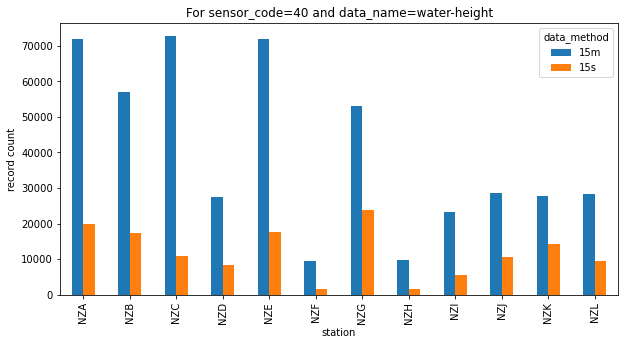

In [20]:
ax = rc['record_count']['40']['water-height'].plot.bar(figsize=(10,5))
ax.set_ylabel('record count')
ax.set_title('For sensor_code=40 and data_name=water-height');

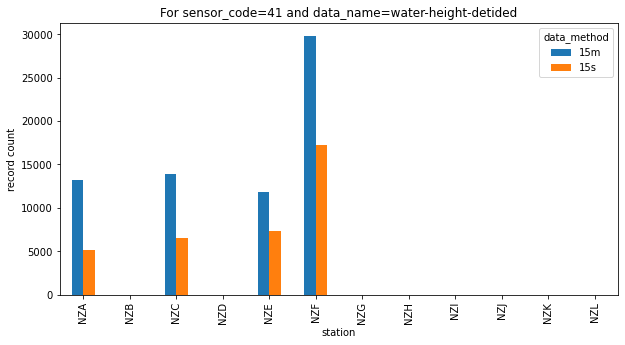

In [21]:
ax = rc['record_count']['41']['water-height-detided'].plot.bar(figsize=(10,5))
ax.set_ylabel('record count')
ax.set_title('For sensor_code=41 and data_name=water-height-detided');

**Creating a data range plot, with stations split by type (15s, 15m) against time**

Creating a dataframe with a new column entry 'statyp' which combines the station and the datatype columns, this will produce a column with values such as NZA_15m, NZA_15s, NZB_15m,...etc. We can then sort by this column using `df.sort_values` and specifying the 'statyp' column which we just generated. To view the output of this, add df or df.head() to a new line in the code cell below and run. This is not completely comprehensive as we are restricting our query to a sensor code of `40`.

In [22]:
#removing the detided rows and '41' sensor codes so we look at just sensor_code 40 and data_name water-height
station_data.drop(station_data.index[station_data['data_name'] == 'water-height-detided'], inplace=True)
station_data.drop(station_data.index[station_data['sensor_code'] == '41'], inplace=True)
station_data.head()

,station,latitude,longitude,sensor_code,data_name,data_method,aspect,record_count,earliestrecord,latestrecord
0,NZA,-42.371,176.911,40,water-height,15m,nil,71956.0,2019-12-21 22:15:00+00:00,2022-01-11 00:00:00+00:00
1,NZA,-42.371,176.911,40,water-height,15s,nil,19803.0,2020-05-08 03:00:00+00:00,2021-12-20 05:24:00+00:00
8,NZB,-40.599,179.096,40,water-height,15m,nil,56870.0,2020-09-18 23:15:00+00:00,2022-05-04 12:00:00+00:00
9,NZB,-40.599,179.096,40,water-height,15s,nil,17246.0,2020-10-28 22:00:00+00:00,2022-01-16 00:59:45+00:00
12,NZC,-38.200,-179.797,40,water-height,15m,nil,72772.0,2019-12-13 02:15:00+00:00,2022-01-11 00:00:00+00:00


In [23]:
station_data['statyp'] = station_data['station'] + '_' + station_data['data_method']
station_data.sort_values('statyp', inplace=True)
station_data.head()

,station,latitude,longitude,sensor_code,data_name,data_method,aspect,record_count,earliestrecord,latestrecord,statyp
0,NZA,-42.371,176.911,40,water-height,15m,nil,71956.0,2019-12-21 22:15:00+00:00,2022-01-11 00:00:00+00:00,NZA_15m
1,NZA,-42.371,176.911,40,water-height,15s,nil,19803.0,2020-05-08 03:00:00+00:00,2021-12-20 05:24:00+00:00,NZA_15s
8,NZB,-40.599,179.096,40,water-height,15m,nil,56870.0,2020-09-18 23:15:00+00:00,2022-05-04 12:00:00+00:00,NZB_15m
9,NZB,-40.599,179.096,40,water-height,15s,nil,17246.0,2020-10-28 22:00:00+00:00,2022-01-16 00:59:45+00:00,NZB_15s
12,NZC,-38.200,-179.797,40,water-height,15m,nil,72772.0,2019-12-13 02:15:00+00:00,2022-01-11 00:00:00+00:00,NZC_15m


We now want to make a new column called 'pos' for position this will be the position on the y-axis to plot the data range line. `len(df)` gets the number of rows in the dataframe, for this example there are 25 rows, so len(df) = 25. Using `len(df) - np.arange(len(df))` we start with 25 (as this is the total number of lines) and then with each row we are getting one less. This allows us to have a position value for each row. 

In [24]:
station_data['pos'] = len(station_data) - np.arange(len(station_data))
station_data.head()

,station,latitude,longitude,sensor_code,data_name,data_method,aspect,record_count,earliestrecord,latestrecord,statyp,pos
0,NZA,-42.371,176.911,40,water-height,15m,nil,71956.0,2019-12-21 22:15:00+00:00,2022-01-11 00:00:00+00:00,NZA_15m,24
1,NZA,-42.371,176.911,40,water-height,15s,nil,19803.0,2020-05-08 03:00:00+00:00,2021-12-20 05:24:00+00:00,NZA_15s,23
8,NZB,-40.599,179.096,40,water-height,15m,nil,56870.0,2020-09-18 23:15:00+00:00,2022-05-04 12:00:00+00:00,NZB_15m,22
9,NZB,-40.599,179.096,40,water-height,15s,nil,17246.0,2020-10-28 22:00:00+00:00,2022-01-16 00:59:45+00:00,NZB_15s,21
12,NZC,-38.200,-179.797,40,water-height,15m,nil,72772.0,2019-12-13 02:15:00+00:00,2022-01-11 00:00:00+00:00,NZC_15m,20


Now we can set up the labeling for station name vs yvalue. To set the variable 'station_list' we use the 'statyp' values from the dataframe, this way we will have entries for each station and datatype. The yvals are used to set the spacing between the yticks in the next plot. By using `range` which is `range([start], stop [,step])`. We can generate a list that starts at 25 (from len(df)), stops at 0 and steps by -1 (as we want to decrease from 25 to 0 in 1 tick increments).

In [25]:
station_list = station_data['statyp'].values
yvals = range((len(station_data)),0,-1)

Now we want to visualise this data. We will need to import cycle and islice from itertools which are functions created for efficient looping (https://docs.python.org/3/library/itertools.html), this will be used for alternating colours lines for 15m and 15s. This is not required, but makes it easier to distinguish 15m and 15s.

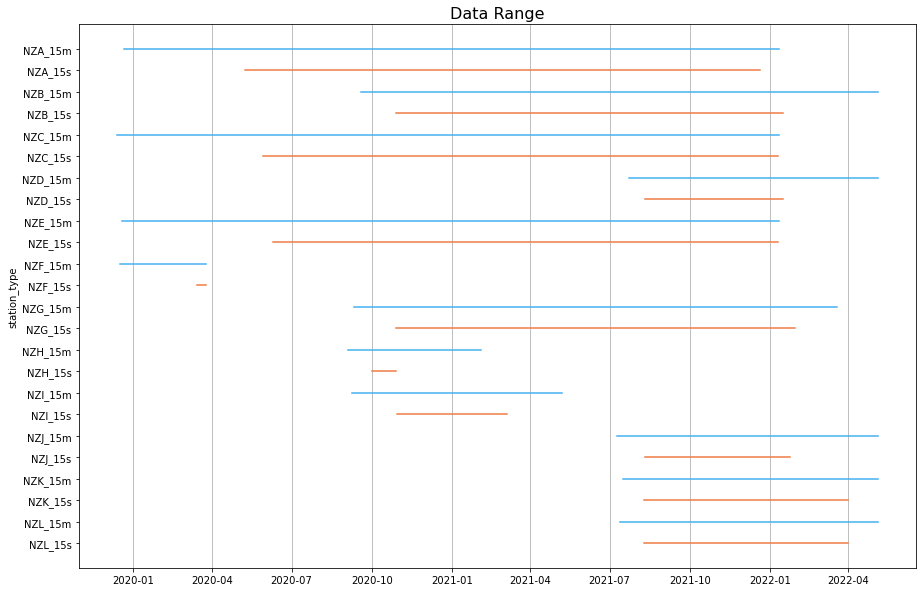

In [26]:
#data visualization of data range plot
from itertools import cycle, islice

fig,ax = plt.subplots(figsize=(15,10))

#alternate colours, so 15m and 15s coloured differently
my_colors = list(islice(cycle(['#41b0f0', '#f07b41']), None, len(station_data)))

#setting different variables, x1=earliest record, x2=latest record, y=position and c=colours of lines.
#when using ax.plot, we are going from the earliest to the latest record on the x-axis, and the y-axis is set by
#position, with the colour being specified by 'my_colors'.
for x1, x2, y, c in zip(station_data['earliestrecord'], station_data['latestrecord'], station_data['pos'], my_colors):
    ax.plot([x1, x2], [y, y], color=c)

#label y-axis with station_type name
ax.set_yticks(yvals)
ax.set_yticklabels(station_list)

ax.grid(axis='x')

ax.set_title('Data Range', fontsize=16)
ax.set_ylabel('station_type');